In [1]:
import re
import operator
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

from wordcloud import WordCloud
from visualization_methods import VisualizationMethods as vm
from aggregation_methods import AggregationMethods as am
import data_methods as dm

df = dm.get_valid_dataframe()
df = df[df['repo_last_modified'] >= '2021-01-01T00:00:00:000']

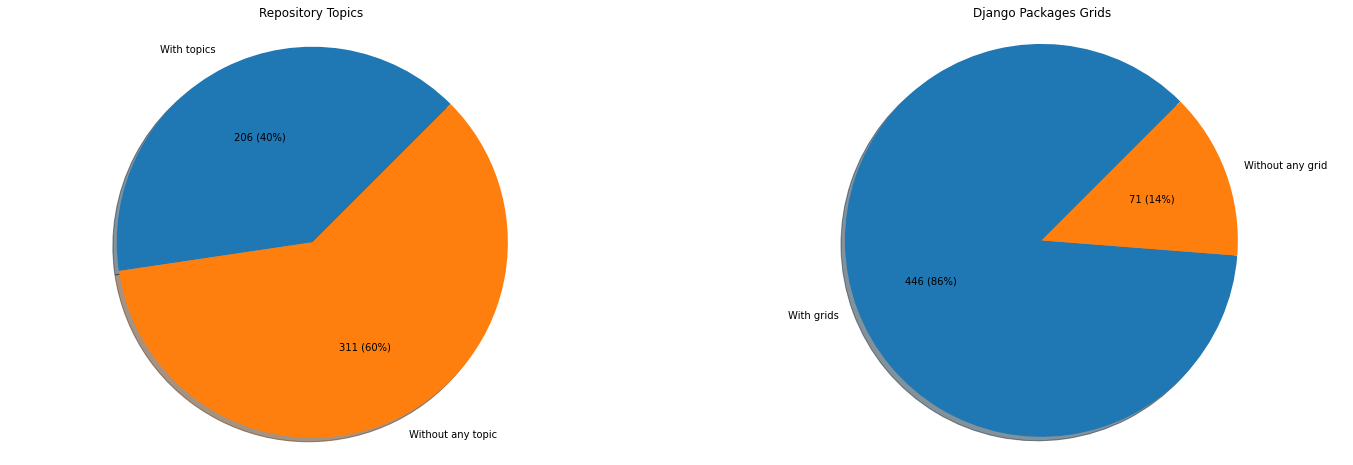

In [2]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))
fig.set_facecolor('white')

sizes = [len(df[~df['repo_topics'].isnull()]), len(df[df['repo_topics'].isnull()])]
vm.set_pie_by_ax(ax1, sizes, ('With topics', 'Without any topic'), 'Repository Topics')

sizes = [len(df[~df['dp_grids'].isnull()]), len(df[df['dp_grids'].isnull()])]
vm.set_pie_by_ax(ax2, sizes, ('With grids', 'Without any grid'), 'Django Packages Grids')

plt.show()

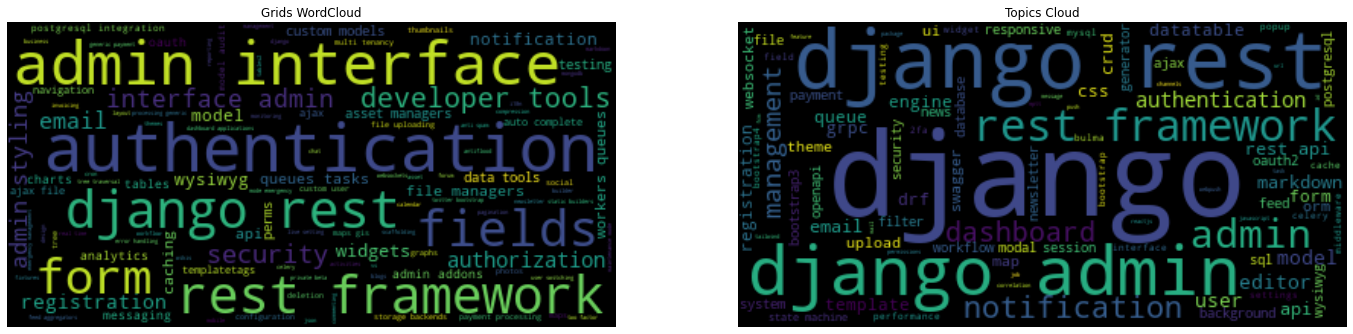

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
fig.set_facecolor('white')

grid_concate, grids_freq, grids_freq_by_stars = (
    am.get_concate_and_freqs(df, 'dp_grids', 'repo_stars', ['this-site'])
)

ax1.set_title('Grids WordCloud')
ax1.imshow(WordCloud().generate(grid_concate), interpolation='bilinear')
ax1.axis("off")

unwanted_topics = [ 'django', 'python', 'django-application', 'django-framework' ]
unwanted_regex = [ 
    re.compile(r'^(django)((\d+)|(\-\d+)|\Z)', re.IGNORECASE), 
    re.compile(r'^(python)((\d+)|(\-.*)|\Z)', re.IGNORECASE), 
    re.compile(r'^(hacktoberfest)((\-\d+)|(\d+)|\Z)', re.IGNORECASE)
]

topics_concate, topics_freq, topics_freq_by_stars = (
    am.get_concate_and_freqs(df, 'repo_topics', 'repo_stars', unwanted_topics, unwanted_regex)
)

ax2.set_title('Topics Cloud')
ax2.imshow(WordCloud().generate(topics_concate), interpolation='bilinear')
ax2.axis("off")

plt.show()

/Users/rafaatsouza/Projects/django-packages-miner/visualization/visualization_methods.py:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(keys, rotation=45, ha='right')
/Users/rafaatsouza/Projects/django-packages-miner/visualization/visualization_methods.py:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(keys, rotation=45, ha='right')


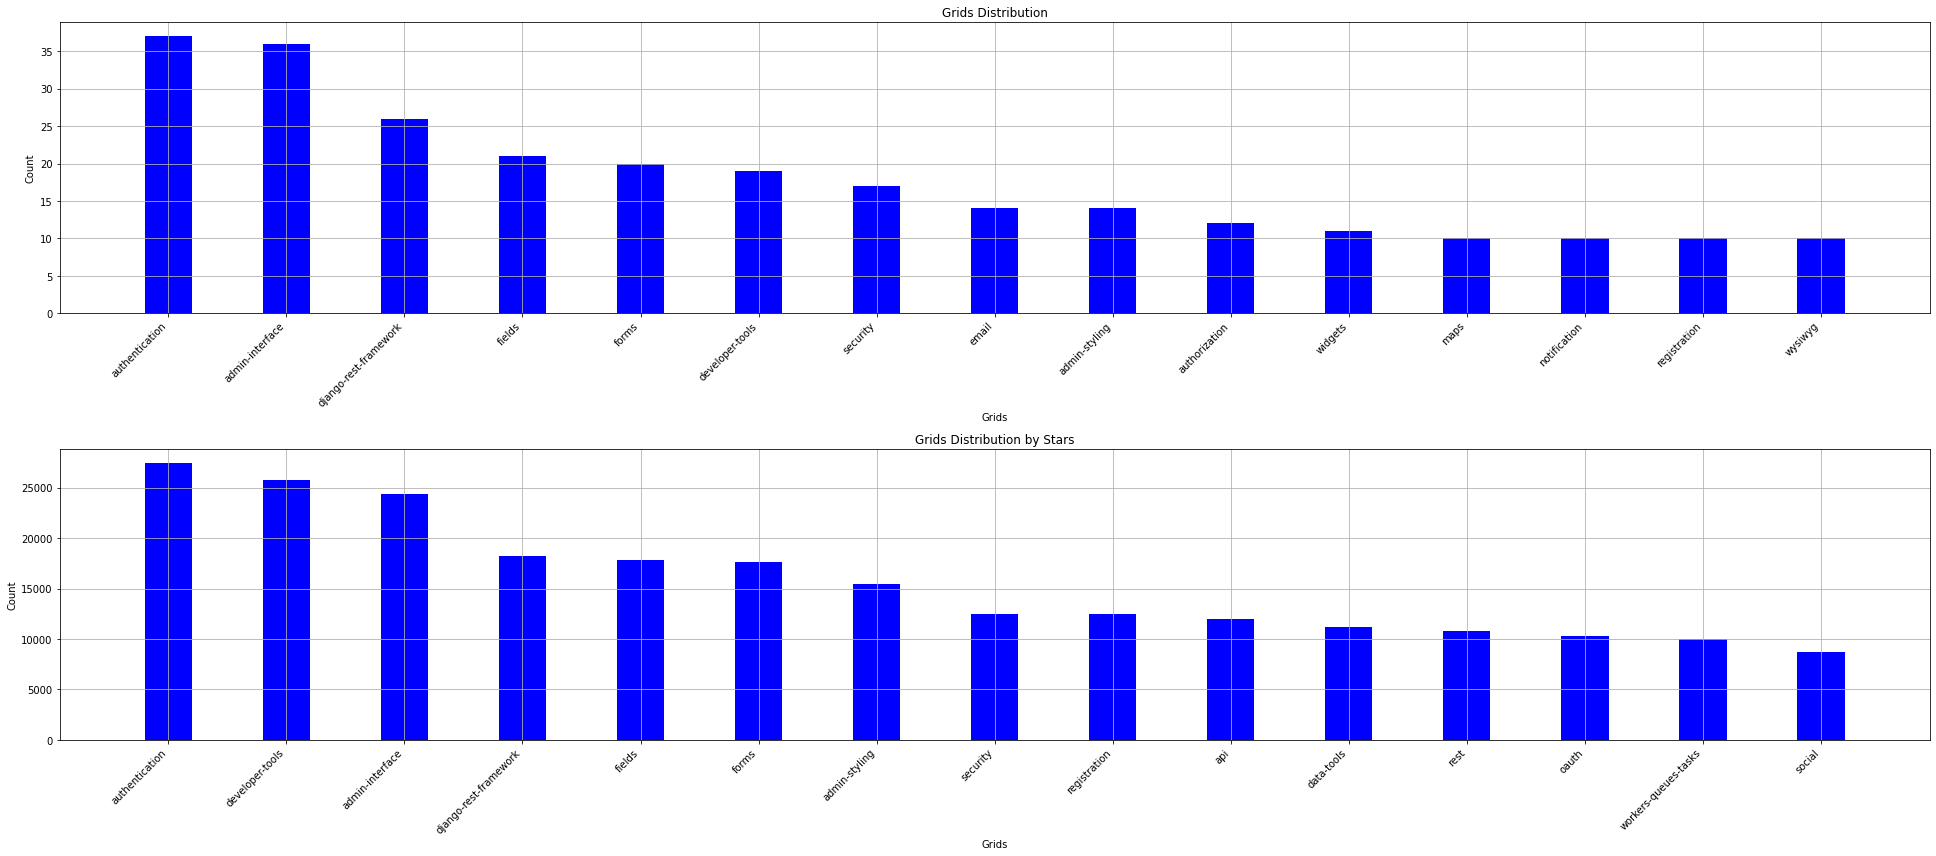

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(27, 12))

top = 15
top_grid_freq = {k[0]: k[1] for k in sorted(grids_freq.items(), key=operator.itemgetter(1), reverse=True)[:top]}
top_grid_freq_by_star = {k[0]: k[1] for k in sorted(grids_freq_by_stars.items(), key=operator.itemgetter(1), reverse=True)[:top]}

vm.show_bar_chart_by_dict_and_ax(ax1, top_grid_freq, 'Grids', 'Count', 'Grids Distribution', 'blue')
vm.show_bar_chart_by_dict_and_ax(ax2, top_grid_freq_by_star, 'Grids', 'Count', 'Grids Distribution by Stars', 'blue')

plt.tight_layout()
plt.show()

/Users/rafaatsouza/Projects/django-packages-miner/visualization/visualization_methods.py:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(keys, rotation=45, ha='right')
/Users/rafaatsouza/Projects/django-packages-miner/visualization/visualization_methods.py:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(keys, rotation=45, ha='right')


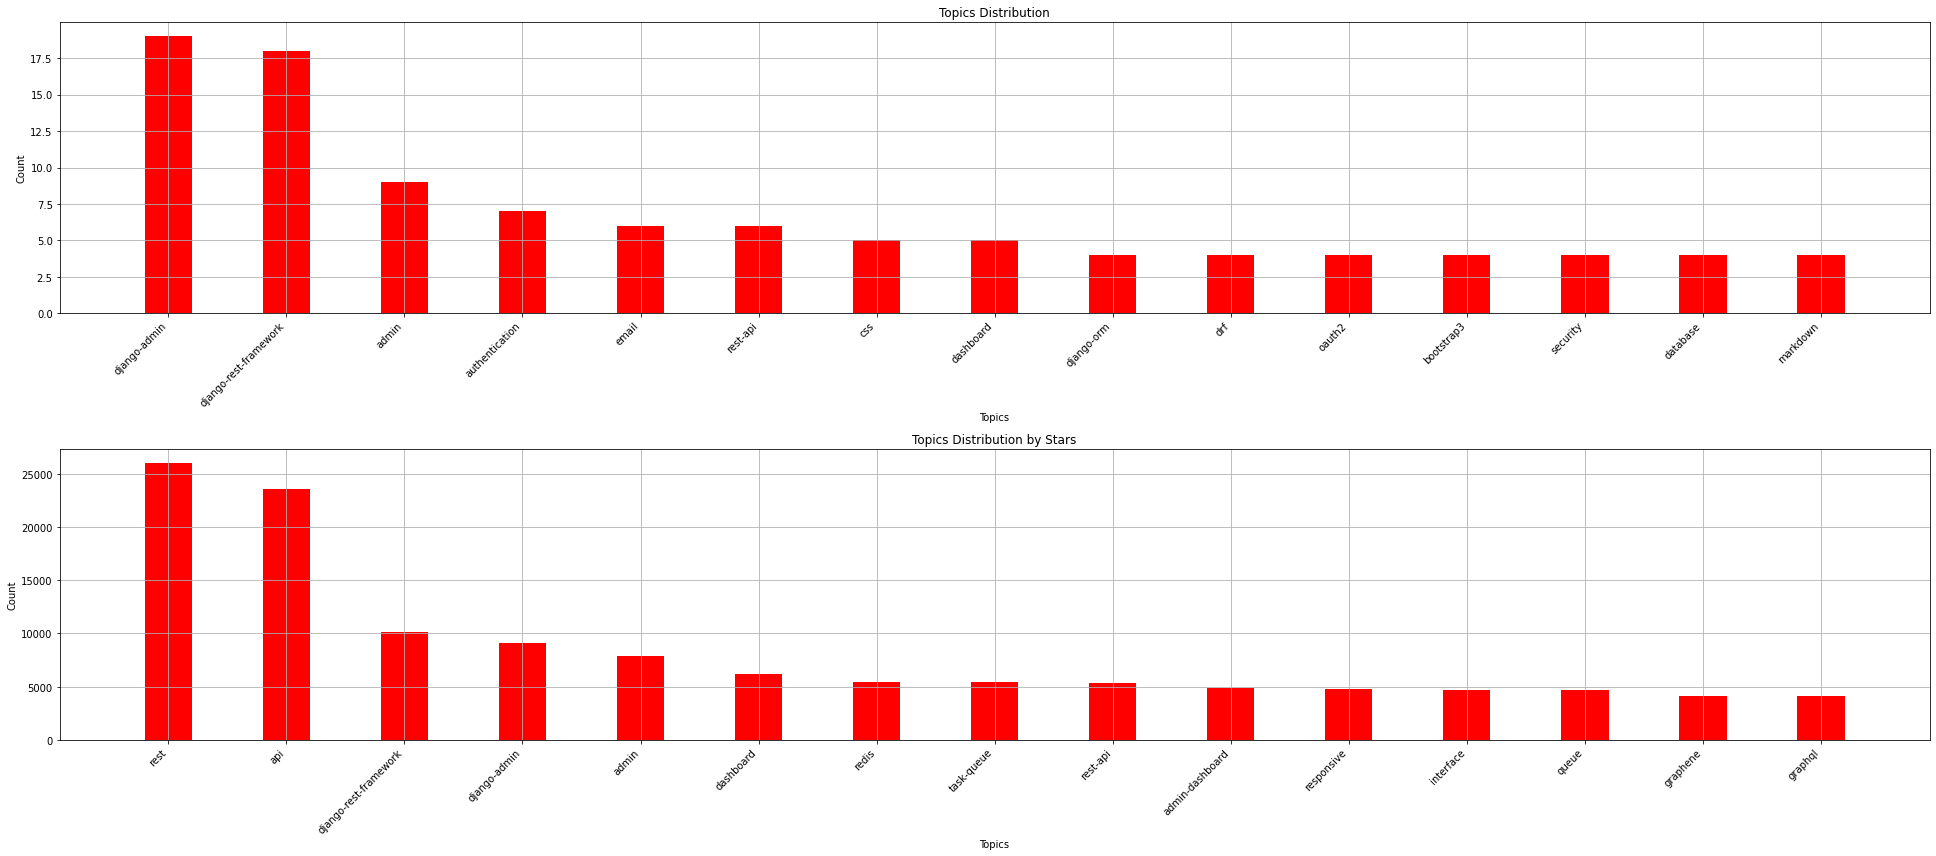

In [5]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(27, 12))

top = 15
top_repo_freq = {k[0]: k[1] for k in sorted(topics_freq.items(), key=operator.itemgetter(1), reverse=True)[:top]}
top_repo_freq_by_star = {k[0]: k[1] for k in sorted(topics_freq_by_stars.items(), key=operator.itemgetter(1), reverse=True)[:top]}

vm.show_bar_chart_by_dict_and_ax(ax1, top_repo_freq, 'Topics', 'Count', 'Topics Distribution', 'red')
vm.show_bar_chart_by_dict_and_ax(ax2, top_repo_freq_by_star, 'Topics', 'Count', 'Topics Distribution by Stars', 'red')

plt.tight_layout()
plt.show()

In [45]:
top_subjects = {
    'admin': ['django-admin', 'admin', 'admin-styling', 'admin-interface', 'admin-dashboard'],
    'fields': ['fields'],
    'forms': ['forms'],
    'email': ['email'],
    'authorization': ['authorization', 'oauth2', 'oauth'],
    'authentication': ['authentication'],
    'security': ['security'],
    'api': ['api', 'rest-api', 'rest', 'django-rest-framework', 'drf', 'graphql', 'graphene'],
    'queue': ['workers-queues-tasks', 'task-queue', 'queue'],
}

def get_subjects(grids, topics):
    subjects = []
    if grids:
        subjects = [k for k,v in top_subjects.items() if any(grid in v for grid in grids)]
    if topics:
        subjects += [k for k,v in top_subjects.items() if any(topic in v for topic in topics)]
    return list(set(subjects))

def get_df_for_filter(df, grid_column, topic_column):
    isna_grid = df[grid_column].isna()
    isna_topics = df[topic_column].isna()
    df.loc[isna_grid, grid_column] = pd.Series([''] * isna_grid.sum()).values
    df.loc[isna_topics, topic_column] = pd.Series([''] * isna_topics.sum()).values
    df['grids'] = df[grid_column].apply(lambda x: x.split(',') if x else [])
    df['topics'] = df[topic_column].apply(lambda x: x.split(',') if x else [])
    return df

def get_df_filtered(df, options):
    df['targets'] = [options] * len(df)
    df['inter_grids'] = [set(x[0]) & set(x[1]) for x in zip(df['grids'], df['targets'])]
    df['inter_topics'] = [set(x[0]) & set(x[1]) for x in zip(df['topics'], df['targets'])]
    df = df[(df['inter_grids'].map(len) > 0) | (df['inter_topics'].map(len) > 0)]
    return (
        df.drop('inter_grids', axis=1).drop('inter_topics', axis=1)
        .drop('grids', axis=1).drop('topics', axis=1).drop('targets', axis=1)
    )


In [68]:
graph = dm.get_authors_graph()
df_authors, df_authors_by_month, df_authors_by_year = dm.get_authors_dataframes()
df_authors = get_df_for_filter(df_authors, 'grids', 'topics')
df_authors_by_month = get_df_for_filter(df_authors_by_month, 'grids', 'topics')
df_authors_by_year = get_df_for_filter(df_authors_by_year, 'grids', 'topics')
df = get_df_for_filter(df, 'dp_grids', 'repo_topics')

sub_graphs = {}
sub_dataframes = {}
sub_dataframes_authors = {}
sub_dataframe_authors_by_month = {}
sub_dataframe_authors_by_year = {}

for subject, options in top_subjects.items():
    sub_dataframes[subject] = get_df_filtered(df.copy(), options)
    sub_dataframes_authors[subject] = get_df_filtered(df_authors.copy(), options)
    sub_dataframe_authors_by_month[subject] = get_df_filtered(df_authors_by_month.copy(), options)
    sub_dataframe_authors_by_year[subject] = get_df_filtered(df_authors_by_year.copy(), options)

    nodes = [n for n,v in graph.nodes(data=True) if any((opt in v['grids'] or opt in v['topics']) for opt in options)]
    subgraph = graph.subgraph(nodes)
    sub_graphs[subject] = subgraph

top_stars_ids = list(df.sort_values(['repo_stars'], ascending=False)[0:29]['repo_id'])
graph_top_stars_nodes = [n for n,v in graph.nodes(data=True) if v['full_id'] in top_stars_ids]
subgraph_top_stars = graph.subgraph(graph_top_stars_nodes)

/var/folders/h4/75h2szxs4wjcwpt33vwgmk1m0000gn/T/ipykernel_73468/1197449907.py:24: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/var/folders/h4/75h2szxs4wjcwpt33vwgmk1m0000gn/T/ipykernel_73468/1197449907.py:25: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



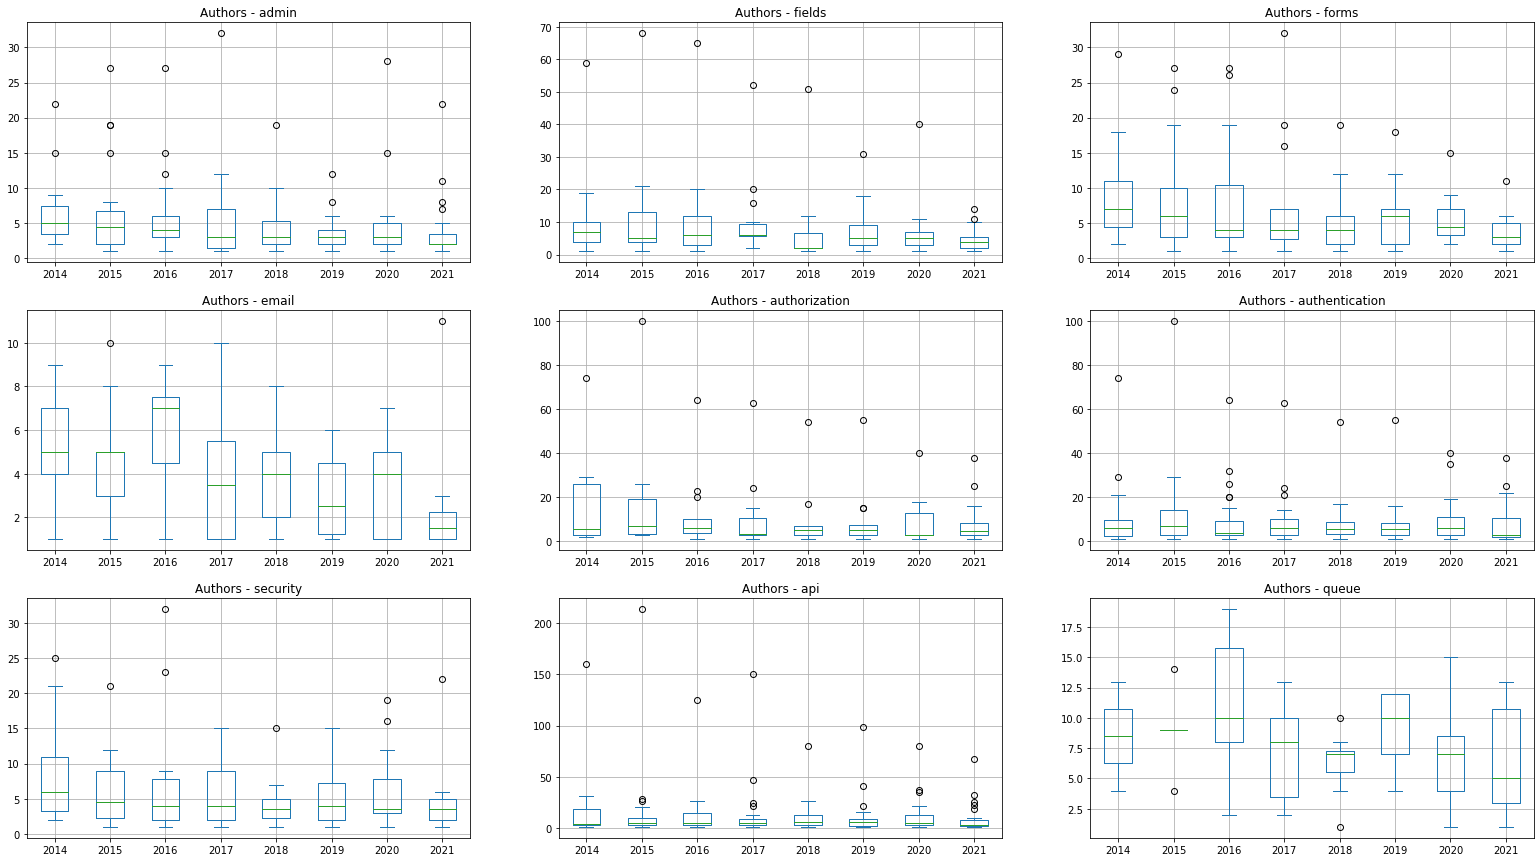

In [8]:
# fig, (row1, row2, row3) = plt.subplots(3, 3, figsize=(27, 15))
# axs = [row1[0], row1[1], row1[2], row2[0], row2[1], row2[2], row3[0], row3[1], row3[2]]
# current_axs_index = 0

# for subject, sub_df in sub_dataframes_authors.items():
#     sub_df_author = sub_df[['repo_id', 'repo_authors']]
#     sub_df_author.drop_duplicates()

#     vm.set_boxplot_by_ax(axs[current_axs_index], sub_df_author['repo_authors'].values, 'Authors - {}'.format(subject))
#     current_axs_index = current_axs_index + 1

# plt.show()
fig, (row1, row2, row3) = plt.subplots(3, 3, figsize=(27, 15))
axs = [row1[0], row1[1], row1[2], row2[0], row2[1], row2[2], row3[0], row3[1], row3[2]]
current_axs_index = 0

for subject, sub_df in sub_dataframe_authors_by_year.items():
    authors_by_year = {}
    for year in sorted(sub_df['year'].unique()):
        authors_by_year[year] = sub_df[sub_df['year'] == year]['authors_count']
    boxplot_data = pd.DataFrame(authors_by_year)
    boxplot_data.plot(ax=axs[current_axs_index], kind='box', title='Authors - {}'.format(subject))
    axs[current_axs_index].grid()
    current_axs_index = current_axs_index + 1

plt.show()

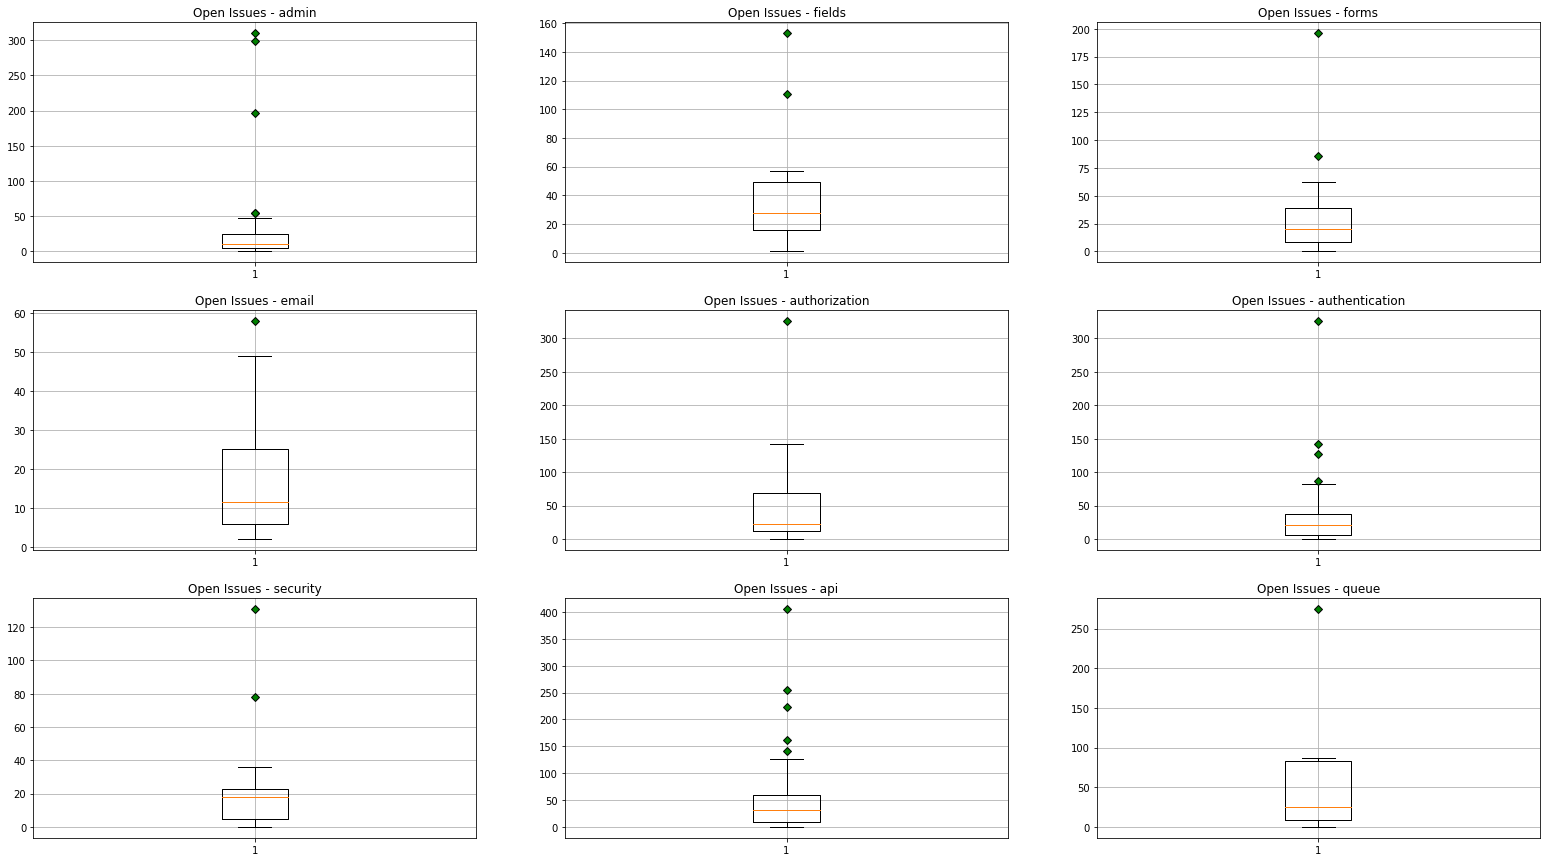

In [9]:
fig, (row1, row2, row3) = plt.subplots(3, 3, figsize=(27, 15))
axs = [row1[0], row1[1], row1[2], row2[0], row2[1], row2[2], row3[0], row3[1], row3[2]]
current_axs_index = 0

for subject, sub_df in sub_dataframes.items():
    vm.set_boxplot_by_ax(axs[current_axs_index], sub_df['repo_open_issues'].values, 'Open Issues - {}'.format(subject))
    current_axs_index = current_axs_index + 1

plt.show()

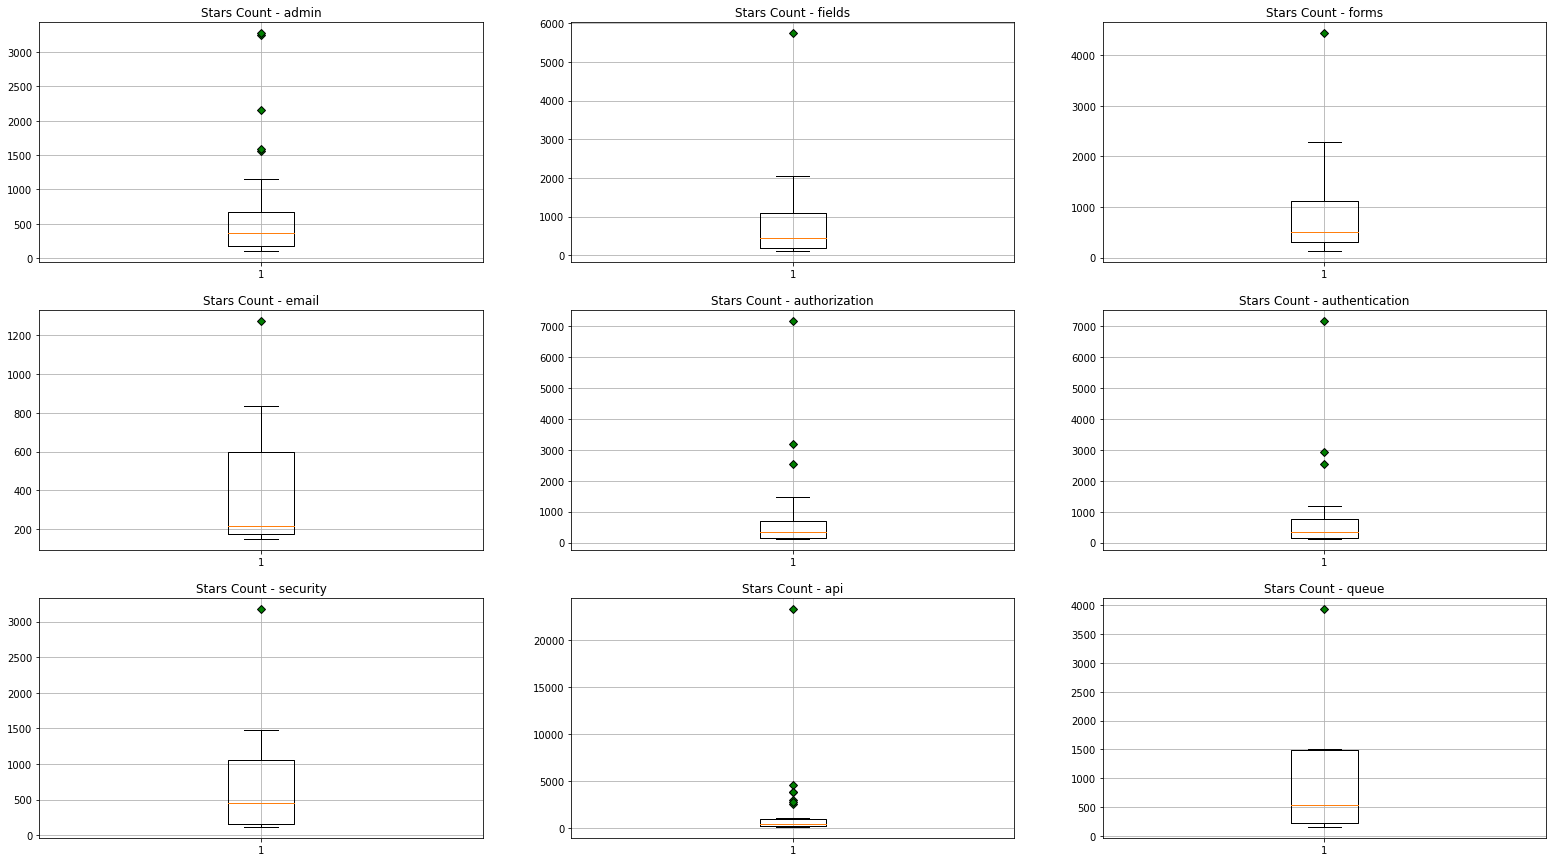

In [10]:
fig, (row1, row2, row3) = plt.subplots(3, 3, figsize=(27, 15))
axs = [row1[0], row1[1], row1[2], row2[0], row2[1], row2[2], row3[0], row3[1], row3[2]]
current_axs_index = 0

for subject, sub_df in sub_dataframes.items():
    vm.set_boxplot_by_ax(axs[current_axs_index], sub_df['repo_stars'].values, 'Stars Count - {}'.format(subject))
    current_axs_index = current_axs_index + 1

plt.show()

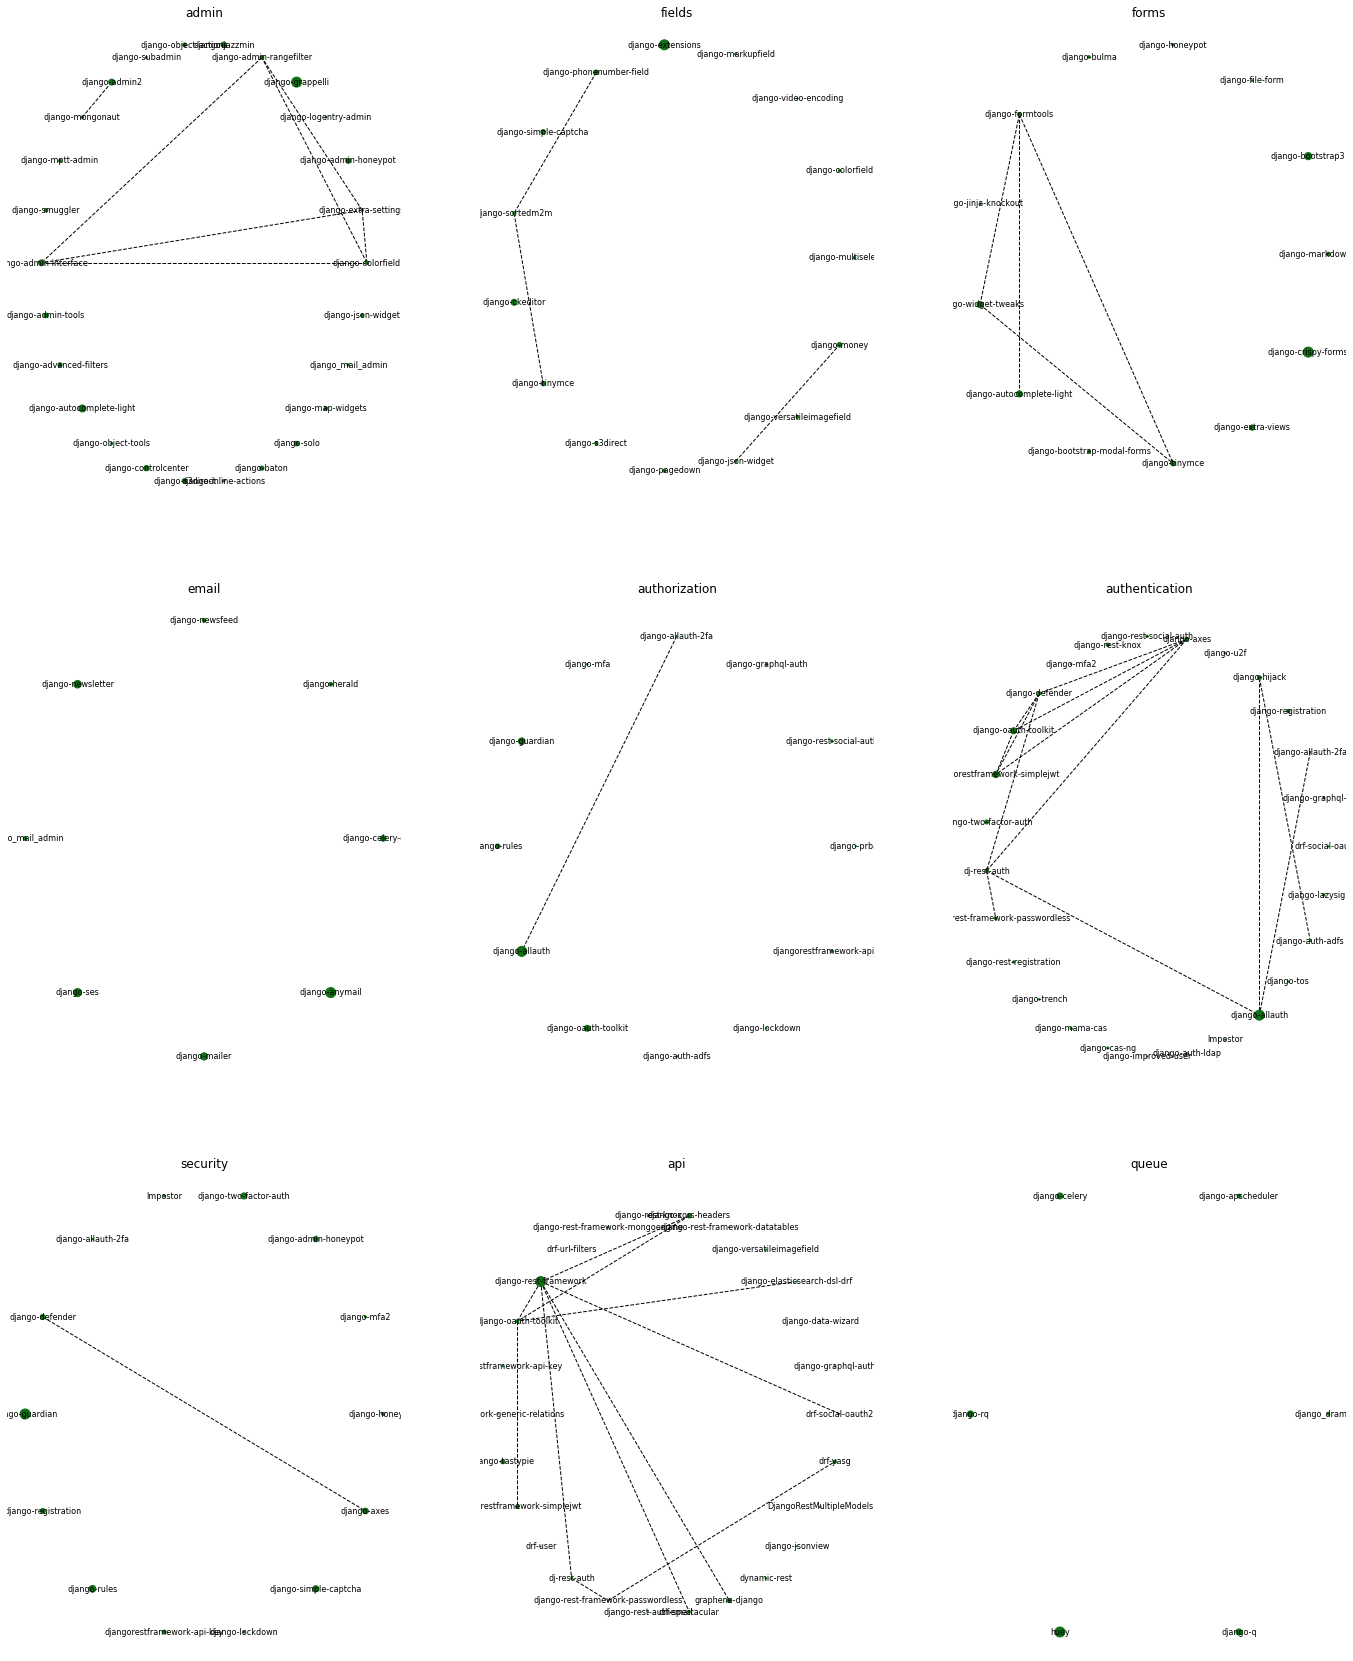

In [11]:
fig, (row1, row2, row3) = plt.subplots(3, 3, figsize=(24, 30))
axs = [row1[0], row1[1], row1[2], row2[0], row2[1], row2[2], row3[0], row3[1], row3[2]]
current_axs_index = 0
max_size_node = 100

options = {
    'node_color': '#117016',
    'edge_color': '#000000',
    'font_size': 8,
    'style': 'dashed',
    'with_labels': True,
    'width': 1,
}

for subject, subgraph in sub_graphs.items():
        pos = nx.circular_layout(subgraph)
        ax = axs[current_axs_index]
        ax.set_title(subject)

        stars = [subgraph.nodes.get(n)['stars'] for n in subgraph.nodes]
        authors = [subgraph.nodes.get(n)['authors'] for n in subgraph.nodes]
        max_stars = max(stars)
        max_authors = max(authors)
        sizes = [(stars[i]*authors[i])/((max_stars*max_authors)/max_size_node) for i in range(len(stars))]
        sizes = [star/(max_stars/max_size_node) for star in stars]

        nx.draw(subgraph, ax=ax, node_size=sizes, pos=pos, **options)
        current_axs_index = current_axs_index + 1


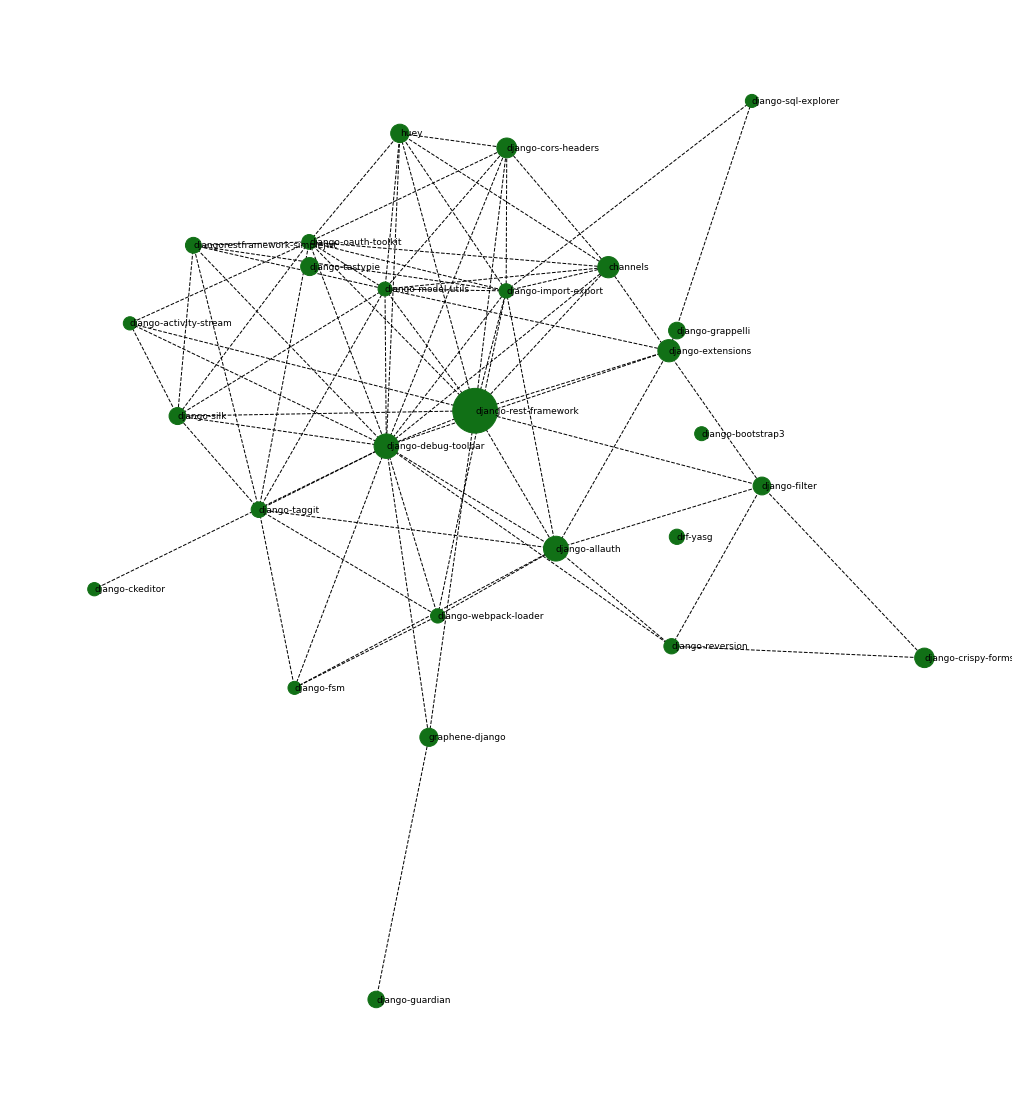

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(18, 20))
max_size_node = 2000

options = {
    'node_color': '#117016',
    'edge_color': '#000000',
    'font_size': 9,
    'style': 'dashed',
    'with_labels': True,
    'width': 1,
    'horizontalalignment': 'left'
}

# pos = nx.circular_layout(subgraph_top_stars)
pos = nx.kamada_kawai_layout(G=subgraph_top_stars)
stars = [subgraph_top_stars.nodes.get(n)['stars'] for n in subgraph_top_stars.nodes]
max_stars = max(stars)
sizes = [max_size_node*stars[i]/max_stars for i in range(len(stars))]

nx.draw(subgraph_top_stars, ax=ax, node_size=sizes, pos=pos, **options)
# ax.set_xlim([1.5*x for x in ax.get_xlim()])
# ax.set_ylim([1.5*y for y in ax.get_ylim()])



In [72]:
import plotly.graph_objects as go


edge_x = []
edge_y = []
for edge in subgraph_top_stars.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in subgraph_top_stars.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='Hot',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Repository stars',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

node_stars = []
node_text = []
description_base = '<b>{}</b><br><b>Subjects: </b>{}<br><b>Stars: </b>{}<br><b>Connections: </b>{}'

for node, adjacencies in enumerate(subgraph_top_stars.adjacency()):
    node_data = subgraph_top_stars.nodes[list(subgraph_top_stars.nodes())[node]]
    node_stars.append(node_data['stars'])
    subjects = get_subjects(node_data['grids'], node_data['topics'])
    node_text.append(description_base.format(node_data['full_id'], ', '.join(subjects), node_data['stars'], len(adjacencies[1])))

node_trace.marker.color = node_stars
node_trace.text = node_text
# node_trace
fig = go.Figure(data=[edge_trace, node_trace],
    layout=go.Layout(
    title='<br>Network graph made with Python',
    titlefont_size=16,
    showlegend=False,
    hovermode='closest',
    margin=dict(b=20,l=5,r=5,t=40),
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
    )
fig.show()